# <span style="color:lightblue"><center> **CLASSIFICAÇÃO - EPISÓDIOS DE MORTE**</center></span>

---
### Importando as Bibliotecas
---

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump
from sklearn import tree

---
### Importação dos Dados
---

* Antes de tudo vamos importar o csv "liver_cirrhosis_v3". Essa versão foi separada previamente durante a etapa de limpeza de dados, removendo algumas variáveis da tabela e deixando apenas as mais relevantes para a classificação de casos de morte. Esses atributos são:

    - `Situação (Sobreviveu, Transplante ou Morte)`
    - `Bilirrubina (mg/dl)`
    - `Albumina (gm/dl)`
    - `Fosfatase Alcalina (U/L)`
    - `Aspartato Aminotransferase (U/L)`
    - `Plaquetas (ml/1000)`
    - `Tempo de Protrombina (s)`
    - `Estágio (1, 2 ou 3)`

In [13]:
df = pd.read_csv("../data/dados_processados/liver_cirrhosis_v3.csv")

df

Situação  Idade  Bilirrubina(mg/dl)  Albumina(gm/dl)  \
0     Sobreviveu  18499                 0.5             4.04   
1     Sobreviveu  19724                 0.5             3.93   
2     Sobreviveu  11839                 0.5             3.54   
3          Morte  16467                 0.7             3.74   
4          Morte  21699                 1.9             3.54   
...          ...    ...                 ...              ...   
9632  Sobreviveu  17897                 0.7             3.49   
9633  Sobreviveu  23376                 1.8             3.24   
9634       Morte  24585                 2.1             3.48   
9635  Sobreviveu  21324                 0.9             3.40   
9636       Morte  28650                 0.8             2.94   

      Fosfatase_Alcalina (U/L)  Aspartato_Aminotransferase(U/L)  \
0                   598.000000                        52.700000   
1                   663.000000                        45.000000   
2                  1243.000000                       122.450000   
3                  1024.000000                        77.500000   
4                  1052.000000                       108.500000   
...                        ...                              ...   
9632               1982.655769                       122.556346   
9633               1982.655769                       122.556346   
9634               2045.000000                        89.900000   
9635               1098.000000                       122.450000   
9636               1794.000000                       130.200000   

      Plaquetas(ml/1000)  Tempo_de_Protrombina(s)  Estágio  
0                  256.0                      9.9        1  
1                  220.0                     10.8        2  
2                  225.0                     10.0        2  
3                  151.0                     10.2        2  
4                  151.0                     11.5        1  
...                  ...                      ...      ...  
9632               243.0                      9.7        1  
9633               139.0                     10.5        1  
9634               412.0                     11.8        3  
9635               228.0                     10.3        2  
9636                97.0                     11.2        3  

[9637 rows x 9 columns]

<br><br>

A seguir, a seção Classificação 1 possui explicações detalhadas sobre cada trecho. Nas seções seguintes (Classificação 2 e 3) serão feitas as mesmas análises, porém com ajustes nas classes.

---
# Classificação 1: Morte, Sobrevivência e Transplante
---

## **Divisão para Treino/Teste**

* Com o dataset extraído, a próxima etapa será dividir as variáveis X e Y. Como queremos classificar a coluna "Situação" e prever os casos de "sobrevivência, morte e transplante", vamos definir essa coluna como sendo a Y. O resto das colunas usaremos como valores de entrada sendo a variável X

* Além disso, vamos também dividir cada uma de nossas variáveis em duas partes, uma fração para treinos e outra para testes. Nesse caso, decidimos dividir 80% dos valores para treino e o restante, que seria 20%, para os testes mais para frente. Perceba que esse dataset tem 9637 linhas, logo ficarão 7709 linhas para treino e 1928 para testes.

In [14]:
df1 = df.copy()

# Obtendo as variáveis x e y para treinar o modelo 
X1  = df1.drop(columns=['Situação']).values
y1 = df1['Situação'].values

# Dividindo 80% da matriz para treinar o modelo e 20% para os testes
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)
print("Tamanho separado para treinos: " + str(len(X_train1)))
print("Tamanho separado para testes: " + str(len(X_test1)) + "\n")

print(X1)
print(y1)

Tamanho separado para treinos: 7709
Tamanho separado para testes: 1928

[[1.8499e+04 5.0000e-01 4.0400e+00 ... 2.5600e+02 9.9000e+00 1.0000e+00]
 [1.9724e+04 5.0000e-01 3.9300e+00 ... 2.2000e+02 1.0800e+01 2.0000e+00]
 [1.1839e+04 5.0000e-01 3.5400e+00 ... 2.2500e+02 1.0000e+01 2.0000e+00]
 ...
 [2.4585e+04 2.1000e+00 3.4800e+00 ... 4.1200e+02 1.1800e+01 3.0000e+00]
 [2.1324e+04 9.0000e-01 3.4000e+00 ... 2.2800e+02 1.0300e+01 2.0000e+00]
 [2.8650e+04 8.0000e-01 2.9400e+00 ... 9.7000e+01 1.1200e+01 3.0000e+00]]
['Sobreviveu' 'Sobreviveu' 'Sobreviveu' ... 'Morte' 'Sobreviveu' 'Morte']


## **Normalização dos Dados**

* Seguindo, agora é hora de normalizar os dados que separamos. Para isso é utilizado o objeto **StandardScaler** e seus métodos *fit_transform()* e *fit()*. Depois de ser aplicada a normalização, nós salvamos o scaler na pasta **scalers** com nome **death_scaler.joblib** para possíveis usos futuros.

In [15]:
# Normalizando os dados extraídos do dataset
scaler1 = StandardScaler()
X_train1 = scaler1.fit_transform(X_train1)
X_test1 = scaler1.transform(X_test1)

# Salvando o scaler para uso futuro
print("O modelo do scaler foi salvo em:")
dump(scaler1, 'scalers/death_scaler.joblib')

O modelo do scaler foi salvo em:


['scalers/death_scaler.joblib']

## **Regressão Logística**

* Nosso primeiro modelo de classificação será utilizando Regressão Logística. Vamos utilizar o objeto **Logistic Regression** e dar um *fit()* para poder treinar nosso modelo, e depois salvar a predição numa variável separada. Os resultados da regressão são exibidos através de uma tabela de resultados, com a precisão de cada classe e acurácia geral, e também uma matriz de confusão com as 3 classes.

* Por fim, o modelo de Regressão Logística é salvo na pasta **models** no arquivo nomeado **death_logreg.joblib** para que seja mais fácil de acessá-lo caso seja necessário.

Report - Regressão Logística:
              precision    recall  f1-score   support

       Morte       0.73      0.58      0.65       756
  Sobreviveu       0.70      0.87      0.78      1067
 Transplante       0.00      0.00      0.00       105

    accuracy                           0.71      1928
   macro avg       0.48      0.48      0.47      1928
weighted avg       0.67      0.71      0.68      1928


Importância dos coeficientes:
                                    Morte  Sobreviveu  Transplante
Idade                            0.131782    0.008272    -0.140055
Bilirrubina(mg/dl)               0.547034   -0.785276     0.238242
Albumina(gm/dl)                 -0.128691    0.097547     0.031144
Fosfatase_Alcalina (U/L)         0.289120    0.043000    -0.332120
Aspartato_Aminotransferase(U/L)  0.085911   -0.158305     0.072393
Plaquetas(ml/1000)               0.010347   -0.080875     0.070528
Tempo_de_Protrombina(s)          0.150734   -0.128557    -0.022177
Estágio               

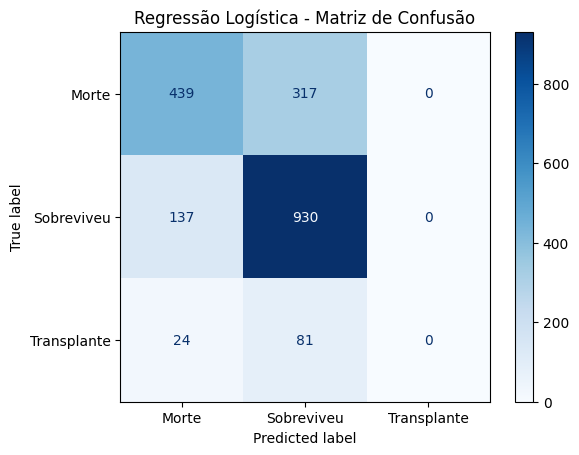

O modelo de Regressão Logística foi salvo em:


['models/death_logreg1.joblib']

In [16]:
# Agora, começar de fato a regressão logística
logreg1 = LogisticRegression(max_iter=4000, n_jobs=-1, C=0.1, penalty='l2')
logreg1.fit(X_train1, y_train1)

# Predict do teste
y_pred1 = logreg1.predict(X_test1)

# Tabela de Resultados
print("Report - Regressão Logística:")
print(classification_report(y_test1, y_pred1, zero_division=0))

# Importância dos coeficientes
coefficients1 = logreg1.coef_
importance1 = pd.DataFrame(coefficients1.T, columns = logreg1.classes_, index=df1.drop('Situação', axis=1).columns)
print("\nImportância dos coeficientes:")
print(importance1)

# Matriz de Confusão
print("\n")
matrix1 = confusion_matrix(y_test1, y_pred1)
matrixPlot1 = ConfusionMatrixDisplay(confusion_matrix=matrix1, display_labels=logreg1.classes_)
matrixPlot1.plot(cmap=plt.cm.Blues)
plt.title("Regressão Logística - Matriz de Confusão")
plt.show()

# Salvando o modelo de regressão para uso futuro
print("O modelo de Regressão Logística foi salvo em:")
dump(logreg1, 'models/death_logreg1.joblib')

## **Árvore de Decisão**

* Agora vamos tentar outra alternativa de classificação. Dessa vez, vamos tentar utilizar o algoritmo de Árvore de Decisão, que pode ser útil para nos ajudar a visualizar melhor o que está acontecendo no processo de classificação, e talvez até entregue resultados melhores na acurácia e precisão. 

* Perceba que podemos utilizar as mesmas variáveis X e Y, já que não foram modificadas.

In [17]:
# Instanciar a Árvore de Decisão
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5)

clf1.fit(X_train1, y_train1)

# Predict da Árvore de Decisão
tree_pred1 = clf1.predict(X_test1)

# Tabela de Resultados
print("Report - Árvore de Decisão:")
print(classification_report(y_test1, tree_pred1, zero_division=0))

Report - Árvore de Decisão:
              precision    recall  f1-score   support

       Morte       0.83      0.81      0.82       756
  Sobreviveu       0.85      0.90      0.87      1067
 Transplante       0.85      0.49      0.62       105

    accuracy                           0.84      1928
   macro avg       0.84      0.73      0.77      1928
weighted avg       0.84      0.84      0.84      1928



* Perceba que a acurácia aumentou consideravelmente, de ~70% para ~ 78%. Além disso, a classe **Transplante** que antes estava sendo omitida da classificação agora está sendo classificada corretamente. Maravilha!

* Agora vamos plottar a nossa árvore de decisão, para que possamos visualizar as etapas que o modelo tomou para alcançar tais resultados.

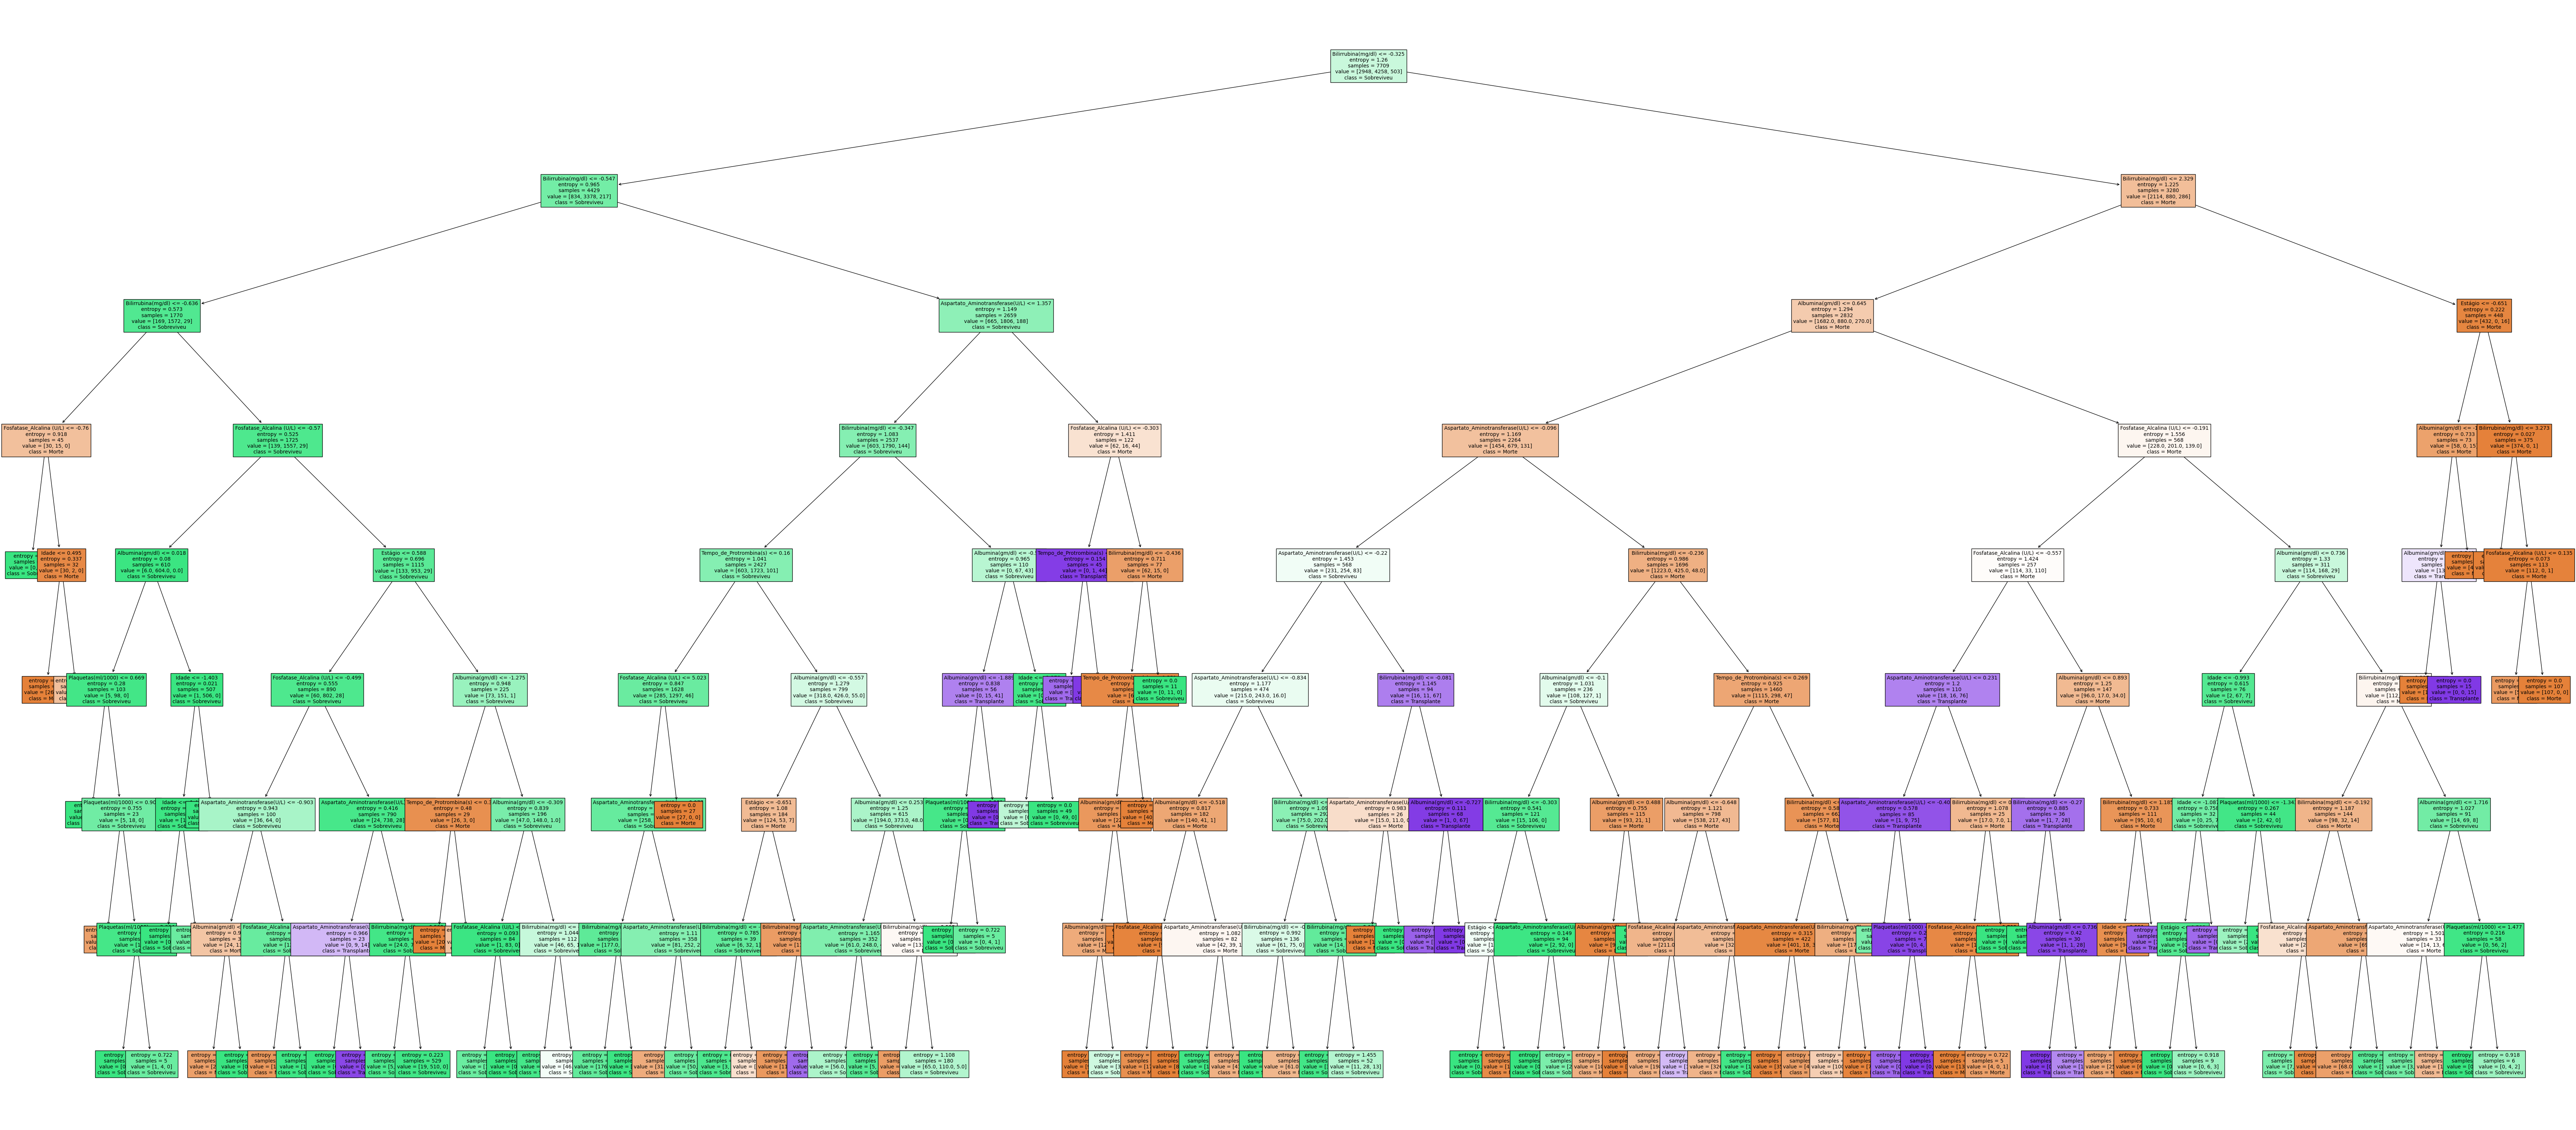

In [18]:
# Plottar a Árvore de Decisão
fig1 = plt.figure(figsize=(90,40))
_ = tree.plot_tree(clf1,
                      feature_names=df1.drop(columns=['Situação']).columns,
                      class_names=clf1.classes_,
                      filled=True,
                      fontsize=10,
                      )

plt.show()

## **Correção na Árvore de Decisão**

* A nossa árvore de decisão está entregando bons resultados, mas está bem ilegível. Para isso, vamos modificar alguns parâmetros para que a análise fique mais sucinta (e de fato possível).

* Primeiramente, vamos realizar uma *Grid Search* para encontrar o melhor valor para **ccp_alpha**, um parâmetro que nos ajuda a regularizar a árvore.

In [19]:
# Grid Search
path1 = clf1.cost_complexity_pruning_path(X_train1, y_train1)

param_grid1 = {'ccp_alpha': path1.ccp_alphas}

CV_clf = GridSearchCV(estimator=clf1, param_grid=param_grid1, cv = 7, verbose=2, n_jobs=-1)
CV_clf.fit(X_train1, y_train1)

best_ccp_alpha1 = CV_clf.best_estimator_.ccp_alpha

Fitting 7 folds for each of 88 candidates, totalling 616 fits


* Com o valor em mãos, agora vamos criar outra árvore de decisão com os parâmetros modifiados, com o objetivo de torná-la mais agradável esteticamente sem que haja uma diminuição muito grande da acurácia.

In [20]:
# Instanciar um novo objeto para a Árvore de Decisão Corrigida
clf_ccp1 = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=4, min_samples_split=20, ccp_alpha=best_ccp_alpha1)

clf_ccp1.fit(X_train1, y_train1)

# Predict da Árvore de Decisão Corrigida
tree_pred1 = clf_ccp1.predict(X_test1)

# Tabela de Resultados
print("Report - Árvore de Decisão Corrigida:")
print(classification_report(y_test1, tree_pred1, zero_division=0))

# Importância dos oeficientes
importances1 = clf_ccp1.feature_importances_
feature_importances1 = pd.DataFrame(
    importances1,
    columns = ['Importance'],
    index=df1.drop('Situação', axis=1).columns
).sort_values(by='Importance', ascending=False)

print("\nImportância das Features:")
print(feature_importances1)

Report - Árvore de Decisão Corrigida:
              precision    recall  f1-score   support

       Morte       0.78      0.74      0.76       756
  Sobreviveu       0.80      0.86      0.83      1067
 Transplante       0.85      0.44      0.58       105

    accuracy                           0.79      1928
   macro avg       0.81      0.68      0.72      1928
weighted avg       0.79      0.79      0.79      1928


Importância das Features:
                                 Importance
Bilirrubina(mg/dl)                 0.533613
Albumina(gm/dl)                    0.137829
Aspartato_Aminotransferase(U/L)    0.137397
Fosfatase_Alcalina (U/L)           0.119743
Tempo_de_Protrombina(s)            0.044427
Estágio                            0.024495
Idade                              0.002496
Plaquetas(ml/1000)                 0.000000


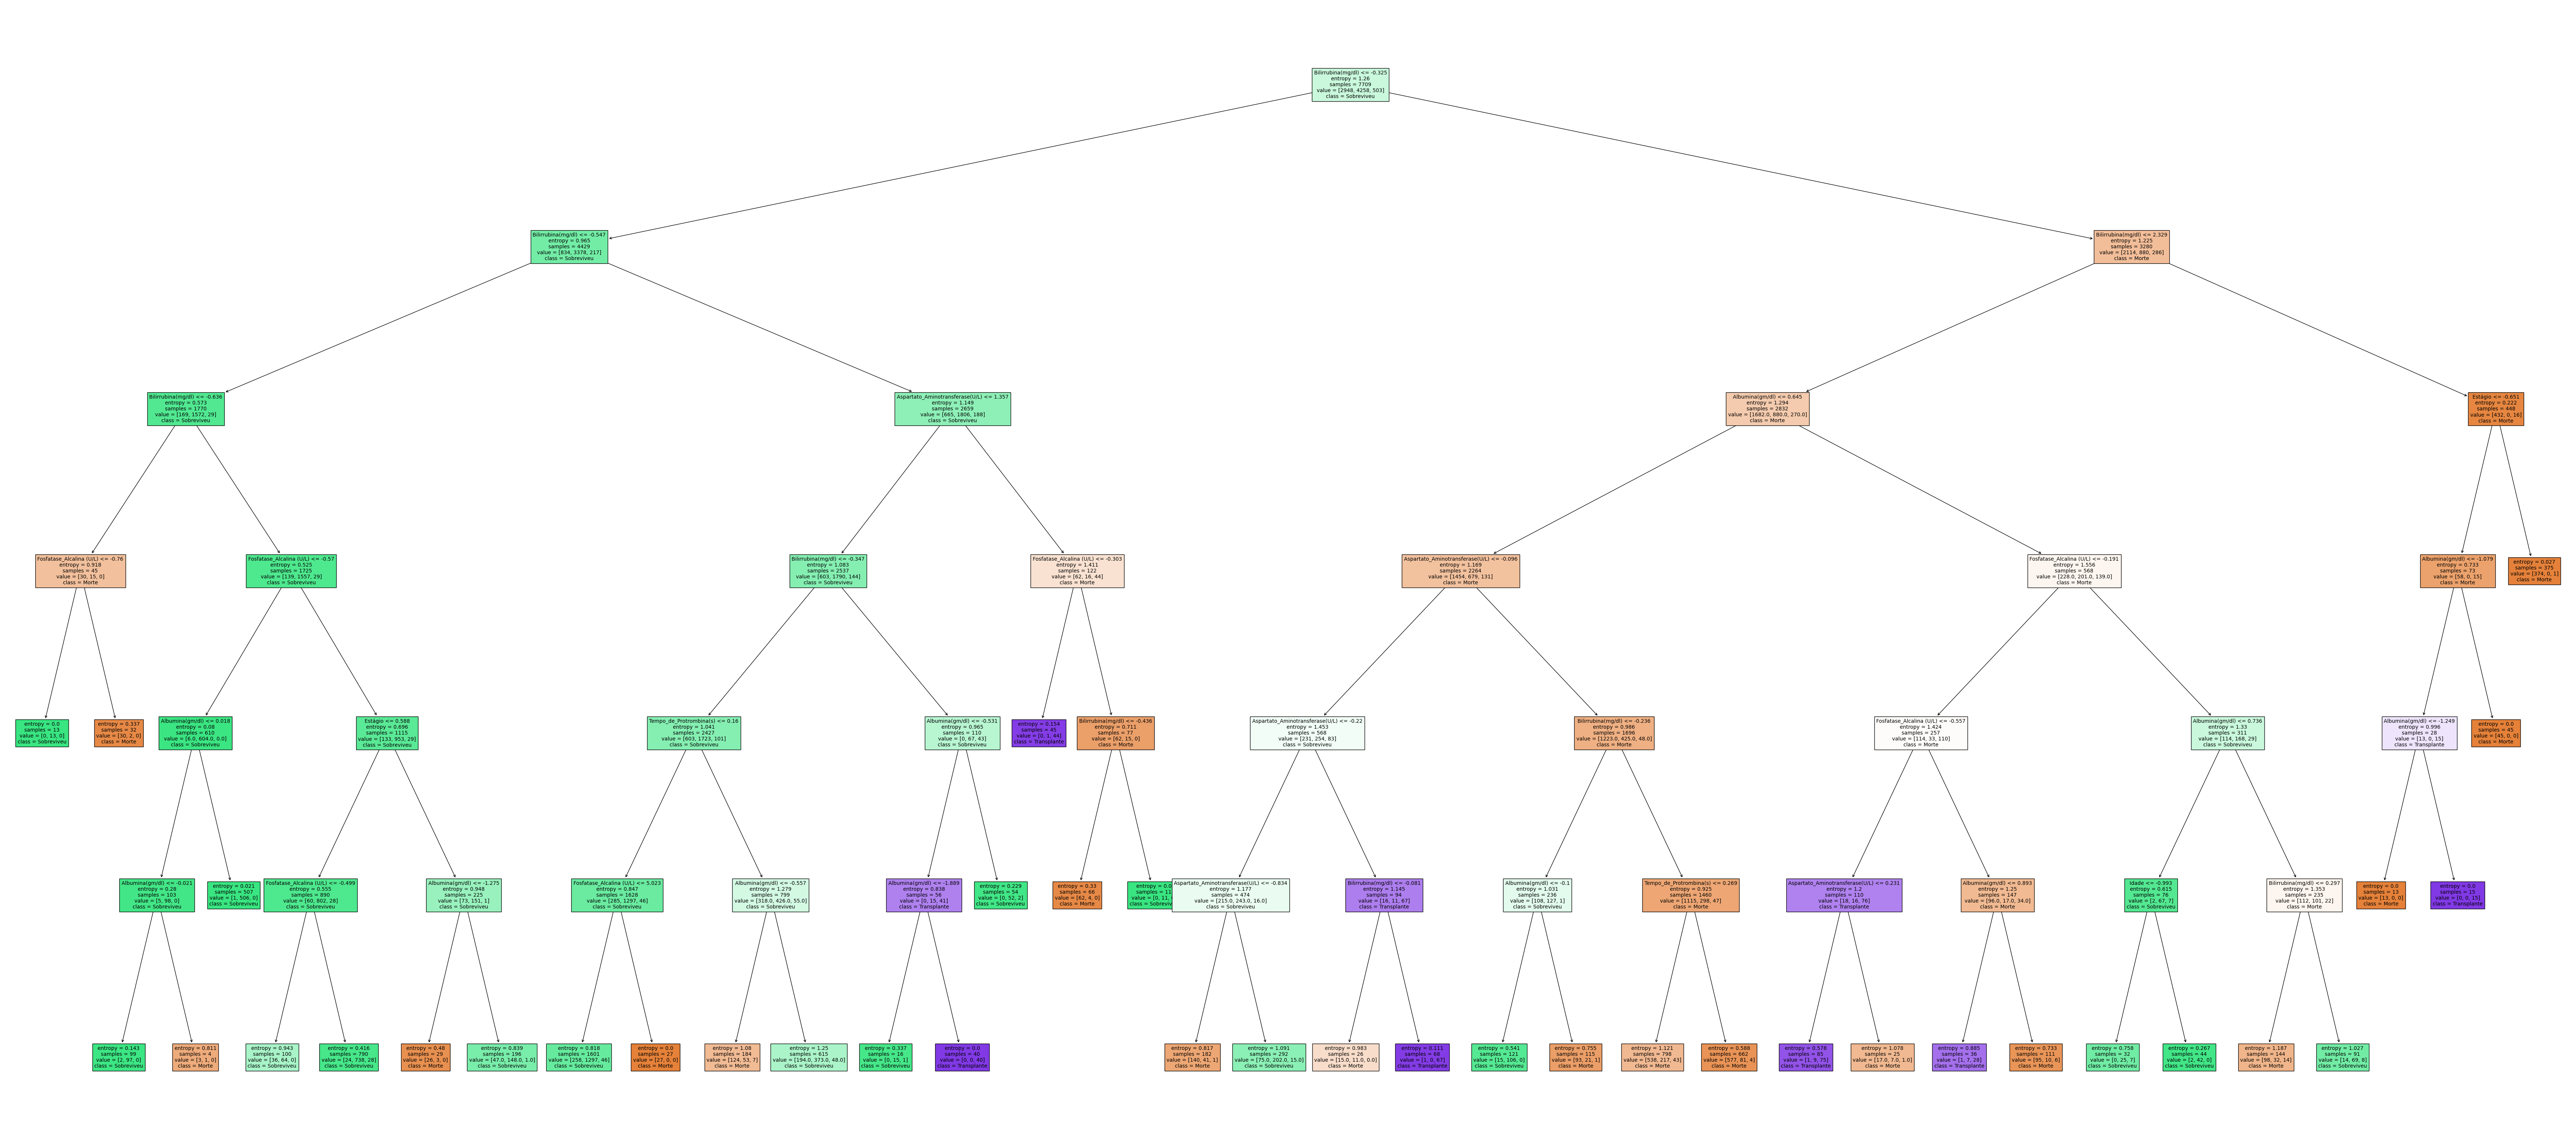

In [21]:
# Plottar a Árvore de Decisão Corrigida
fig_1 = plt.figure(figsize=(90,40))
_ = tree.plot_tree(clf_ccp1,
                      feature_names=df1.drop(columns=['Situação']).columns,
                      class_names=clf_ccp1.classes_,
                      filled=True,
                      fontsize=10,
                      )

plt.show()

* E para finalizar, vamos salvar arquivos dos nossos modelos de árvore de decisão para que possamos usá-las em outra situação.

In [22]:
# Salvando os modelos de árvore de decisão para uso futuro
print("O modelo de Árvore de Decisão foi salvo em:")
dump(clf1, 'models/death_tree1.joblib')

O modelo de Árvore de Decisão foi salvo em:


['models/death_tree1.joblib']

In [23]:
print("O modelo de Árvore de Decisão Corrigida foi salvo em:")
dump(clf_ccp1, 'models/death_tree_fixed1.joblib')

O modelo de Árvore de Decisão Corrigida foi salvo em:


['models/death_tree_fixed1.joblib']

---
# Classificação 2: Mesclando Sobrevivência e Transplante
---

## **Importação e Ajuste dos Dados**

In [24]:
df2 = df.copy()

# Considerando o valor de "Transplante" como "Sobreviveu"
df2['Situação'] = df2['Situação'].replace('Transplante', 'Sobreviveu')

print(df2['Situação'].value_counts())
df2

Situação
Sobreviveu    5933
Morte         3704
Name: count, dtype: int64


Situação  Idade  Bilirrubina(mg/dl)  Albumina(gm/dl)  \
0     Sobreviveu  18499                 0.5             4.04   
1     Sobreviveu  19724                 0.5             3.93   
2     Sobreviveu  11839                 0.5             3.54   
3          Morte  16467                 0.7             3.74   
4          Morte  21699                 1.9             3.54   
...          ...    ...                 ...              ...   
9632  Sobreviveu  17897                 0.7             3.49   
9633  Sobreviveu  23376                 1.8             3.24   
9634       Morte  24585                 2.1             3.48   
9635  Sobreviveu  21324                 0.9             3.40   
9636       Morte  28650                 0.8             2.94   

      Fosfatase_Alcalina (U/L)  Aspartato_Aminotransferase(U/L)  \
0                   598.000000                        52.700000   
1                   663.000000                        45.000000   
2                  1243.000000                       122.450000   
3                  1024.000000                        77.500000   
4                  1052.000000                       108.500000   
...                        ...                              ...   
9632               1982.655769                       122.556346   
9633               1982.655769                       122.556346   
9634               2045.000000                        89.900000   
9635               1098.000000                       122.450000   
9636               1794.000000                       130.200000   

      Plaquetas(ml/1000)  Tempo_de_Protrombina(s)  Estágio  
0                  256.0                      9.9        1  
1                  220.0                     10.8        2  
2                  225.0                     10.0        2  
3                  151.0                     10.2        2  
4                  151.0                     11.5        1  
...                  ...                      ...      ...  
9632               243.0                      9.7        1  
9633               139.0                     10.5        1  
9634               412.0                     11.8        3  
9635               228.0                     10.3        2  
9636                97.0                     11.2        3  

[9637 rows x 9 columns]

* Junção dos dados de sobrevivência e transplante em uma única classe

In [25]:
X2 = df2.iloc[:, 1:].values
y2 = df2.iloc[:, 0].values

## **Separação e Normalização dos Dados**

In [26]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)

scaler2 = StandardScaler()
scaler2.fit(X_train2)
X_train2 = scaler2.transform(X_train2)
X_test2 = scaler2.transform(X_test2)

print("Tamanho treinamento: " + str(len(X_train2)))
print("Tamanho teste: " + str(len(X_test2)))

Tamanho treinamento: 7709
Tamanho teste: 1928


In [27]:
print("O modelo do scaler foi salvo em:")
dump(scaler2, 'scalers/death_scaler2.joblib')

O modelo do scaler foi salvo em:


['scalers/death_scaler2.joblib']

## **Regressão Logistica**

Report - Regressão Logística:
              precision    recall  f1-score   support

       Morte       0.40      0.27      0.32       758
  Sobreviveu       0.61      0.73      0.67      1170

    accuracy                           0.55      1928
   macro avg       0.50      0.50      0.49      1928
weighted avg       0.53      0.55      0.53      1928

Sorted feature importances for class Morte:
Albumina(gm/dl)                    0.207232
Plaquetas(ml/1000)                -0.068144
Idade                             -0.104568
Aspartato_Aminotransferase(U/L)   -0.216628
Fosfatase_Alcalina (U/L)          -0.254859
Tempo_de_Protrombina(s)           -0.268722
Estágio                           -0.317740
Bilirrubina(mg/dl)                -1.087377
Name: 0, dtype: float64




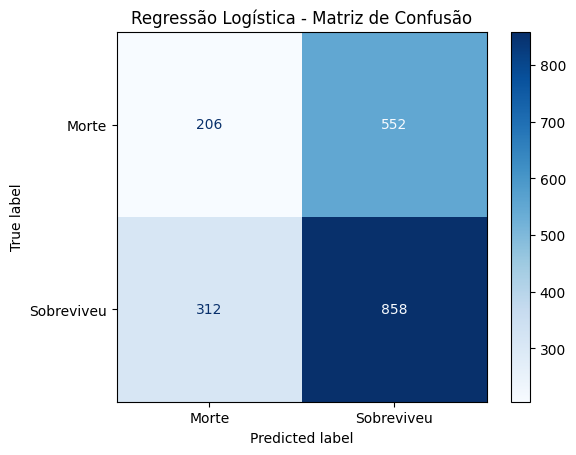

O modelo de Regressão Logística foi salvo em:


['models/death_logreg2.joblib']

In [29]:
# Agora, começar de fato a regressão logística
logreg2 = LogisticRegression(max_iter=4000, n_jobs=-1, C=0.1, penalty='l2')
logreg2.fit(X_train2, y_train2)

# Predict do teste
y_pred2 = logreg2.predict(X_test1)

# Tabela de Resultados
print("Report - Regressão Logística:")
print(classification_report(y_test2, y_pred2, zero_division=0))

# Importância dos coeficientes
feature_names2 = df2.columns[1:]
coefficients2 = logreg2.coef_
coef_df2 = pd.DataFrame(coefficients2, columns=feature_names2)
for idx, class_name in enumerate(logreg2.classes_):
    sorted_coef2 = coef_df2.iloc[idx].sort_values(ascending=False)
    print(f"Sorted feature importances for class {class_name}:")
    print(sorted_coef2)
    break

# Matriz de Confusão
print("\n")
matrix2 = confusion_matrix(y_test2, y_pred2)
matrixPlot2 = ConfusionMatrixDisplay(confusion_matrix=matrix2, display_labels=logreg2.classes_)
matrixPlot2.plot(cmap=plt.cm.Blues)
plt.title("Regressão Logística - Matriz de Confusão")
plt.show()

# Salvando o modelo de regressão para uso futuro
print("O modelo de Regressão Logística foi salvo em:")
dump(logreg2, 'models/death_logreg2.joblib')

## **Árvore de Decisão**

In [31]:
# Instanciar a Árvore de Decisão
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5)

clf2.fit(X_train2, y_train2)

# Predict da Árvore de Decisão
tree_pred2 = clf2.predict(X_test2)

# Tabela de Resultados
print("Report - Árvore de Decisão:")
print(classification_report(y_test2, tree_pred2, zero_division=0))

Report - Árvore de Decisão:
              precision    recall  f1-score   support

       Morte       0.82      0.79      0.80       758
  Sobreviveu       0.87      0.89      0.88      1170

    accuracy                           0.85      1928
   macro avg       0.84      0.84      0.84      1928
weighted avg       0.85      0.85      0.85      1928



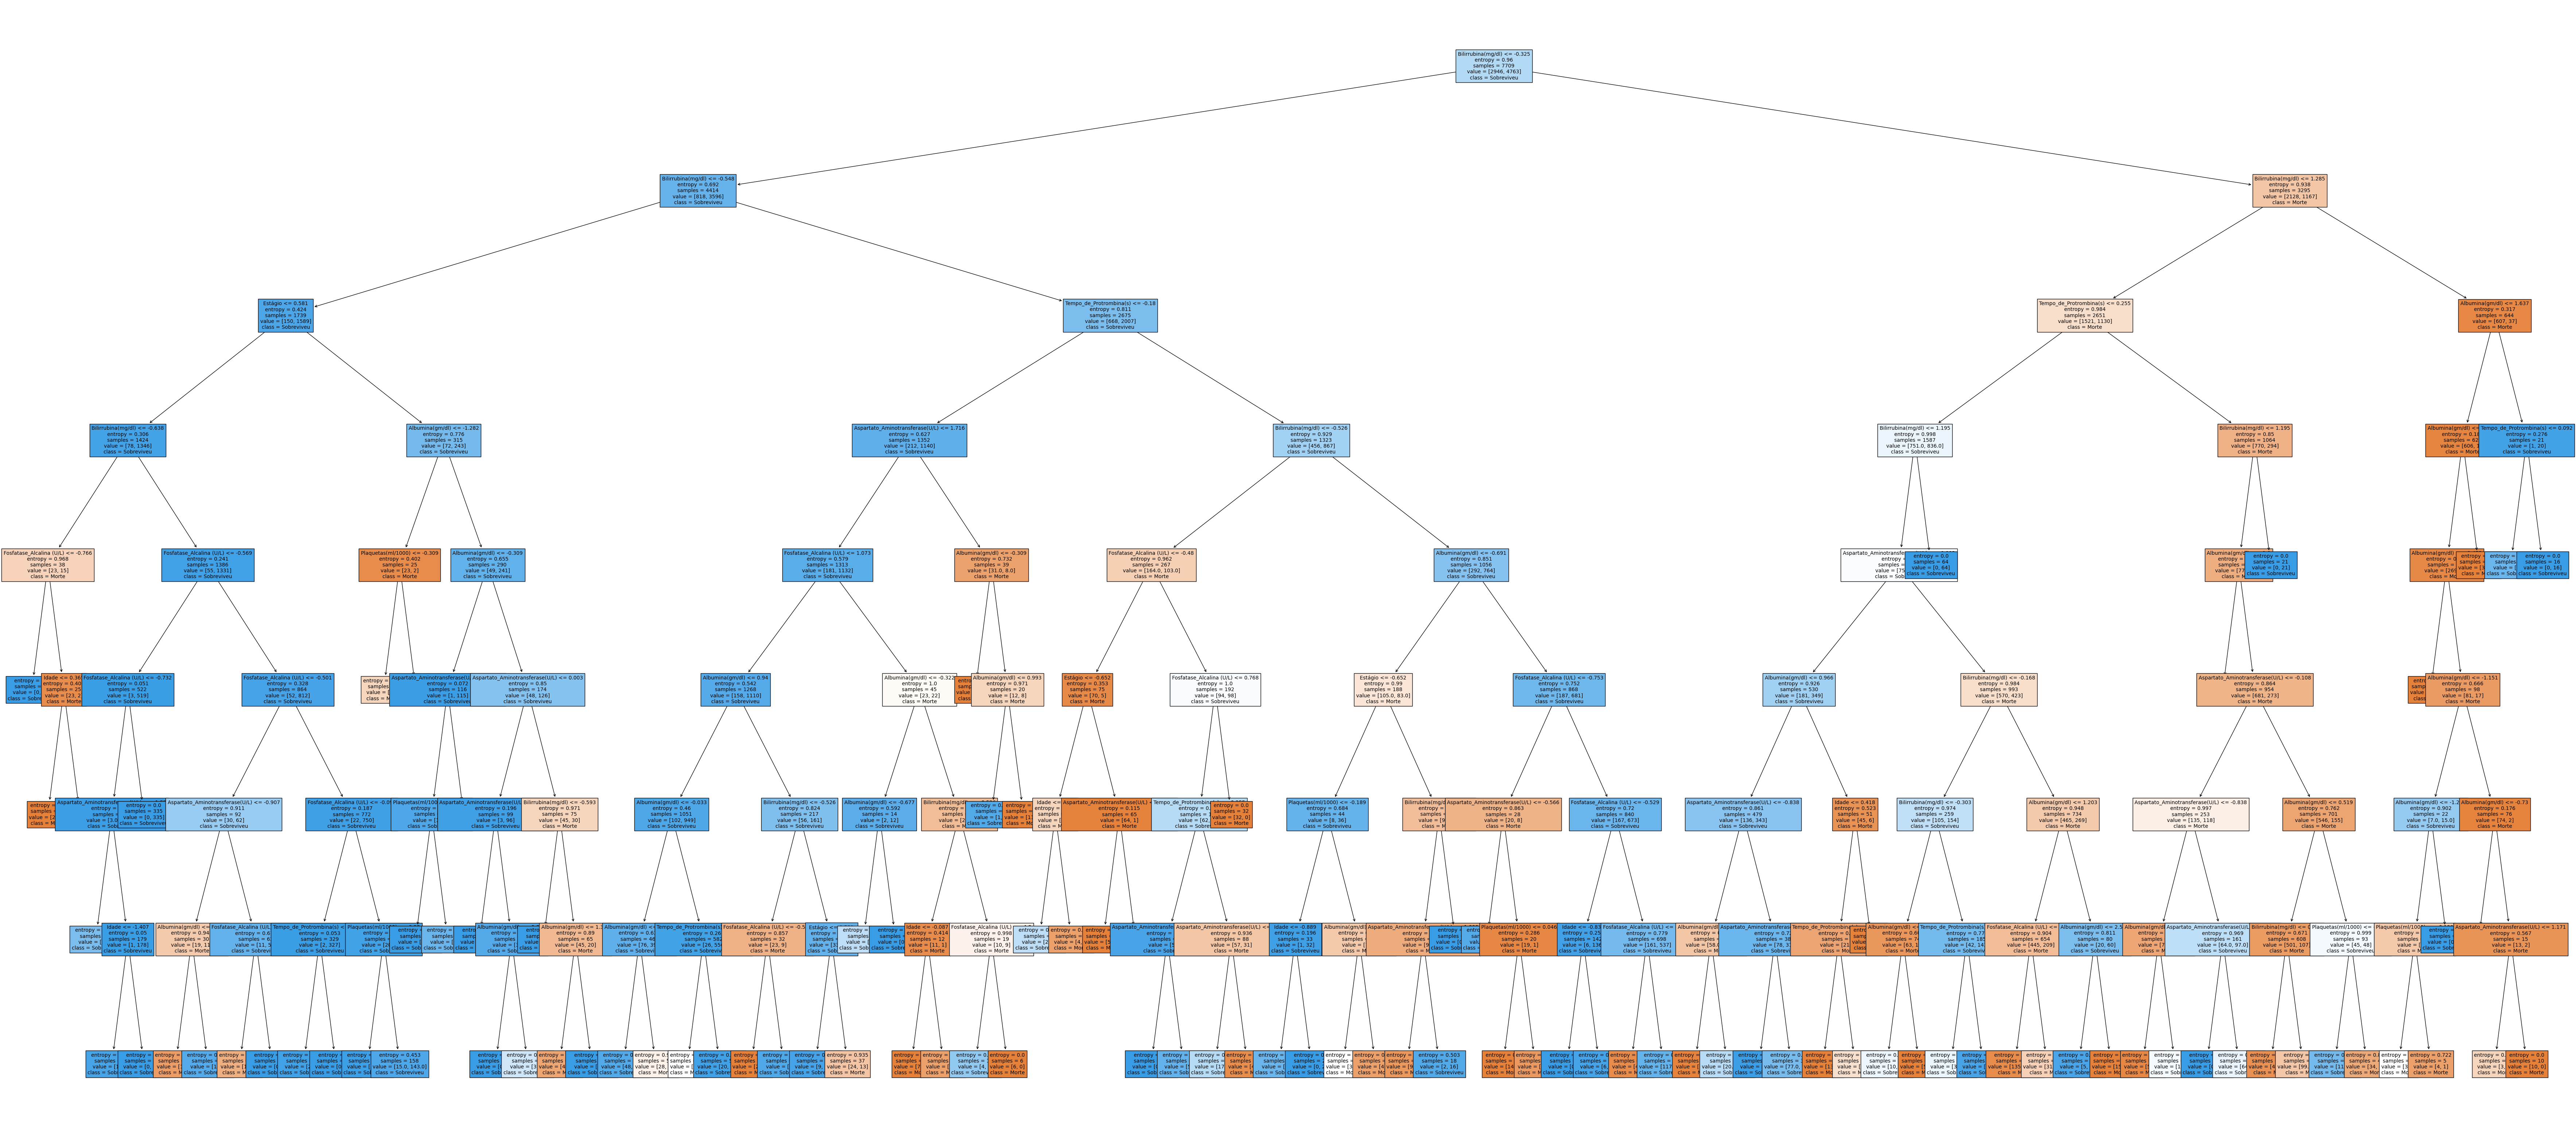

In [32]:
# Plottar a Árvore de Decisão
fig2 = plt.figure(figsize=(90,40))
_ = tree.plot_tree(clf2,
                      feature_names=df2.drop(columns=['Situação']).columns,
                      class_names=clf2.classes_,
                      filled=True,
                      fontsize=10,
                      )

plt.show()

## **Correção na Árvore de Decisão**

In [34]:
# Grid Search
path2 = clf2.cost_complexity_pruning_path(X_train2, y_train2)

param_grid2 = {'ccp_alpha': path2.ccp_alphas}

CV_clf = GridSearchCV(estimator=clf2, param_grid=param_grid2, cv = 7, verbose=2, n_jobs=-1)
CV_clf.fit(X_train2, y_train2)

best_ccp_alpha2 = CV_clf.best_estimator_.ccp_alpha

Fitting 7 folds for each of 75 candidates, totalling 525 fits


In [35]:
# Instanciar um novo objeto para a Árvore de Decisão Corrigida
clf_ccp2 = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=4, min_samples_split=20, ccp_alpha=best_ccp_alpha2)

clf_ccp2.fit(X_train2, y_train2)

# Predict da Árvore de Decisão Corrigida
tree_pred2 = clf_ccp2.predict(X_test2)

# Tabela de Resultados
print("Report - Árvore de Decisão Corrigida:")
print(classification_report(y_test2, tree_pred2, zero_division=0))

# Importância dos coeficientes
importances2 = clf_ccp2.feature_importances_
feature_importances2 = pd.DataFrame(
    importances2, columns = ['Importance'], index=df2.drop('Situação', axis=1).columns).sort_values(by='Importance', ascending=False)

print("\nImportância das Features:")
print(feature_importances2)

Report - Árvore de Decisão Corrigida:
              precision    recall  f1-score   support

       Morte       0.74      0.72      0.73       758
  Sobreviveu       0.82      0.84      0.83      1170

    accuracy                           0.79      1928
   macro avg       0.78      0.78      0.78      1928
weighted avg       0.79      0.79      0.79      1928


Importância das Features:
                                 Importance
Bilirrubina(mg/dl)                 0.616962
Albumina(gm/dl)                    0.138027
Fosfatase_Alcalina (U/L)           0.078570
Tempo_de_Protrombina(s)            0.067540
Aspartato_Aminotransferase(U/L)    0.066593
Estágio                            0.028743
Idade                              0.001918
Plaquetas(ml/1000)                 0.001647


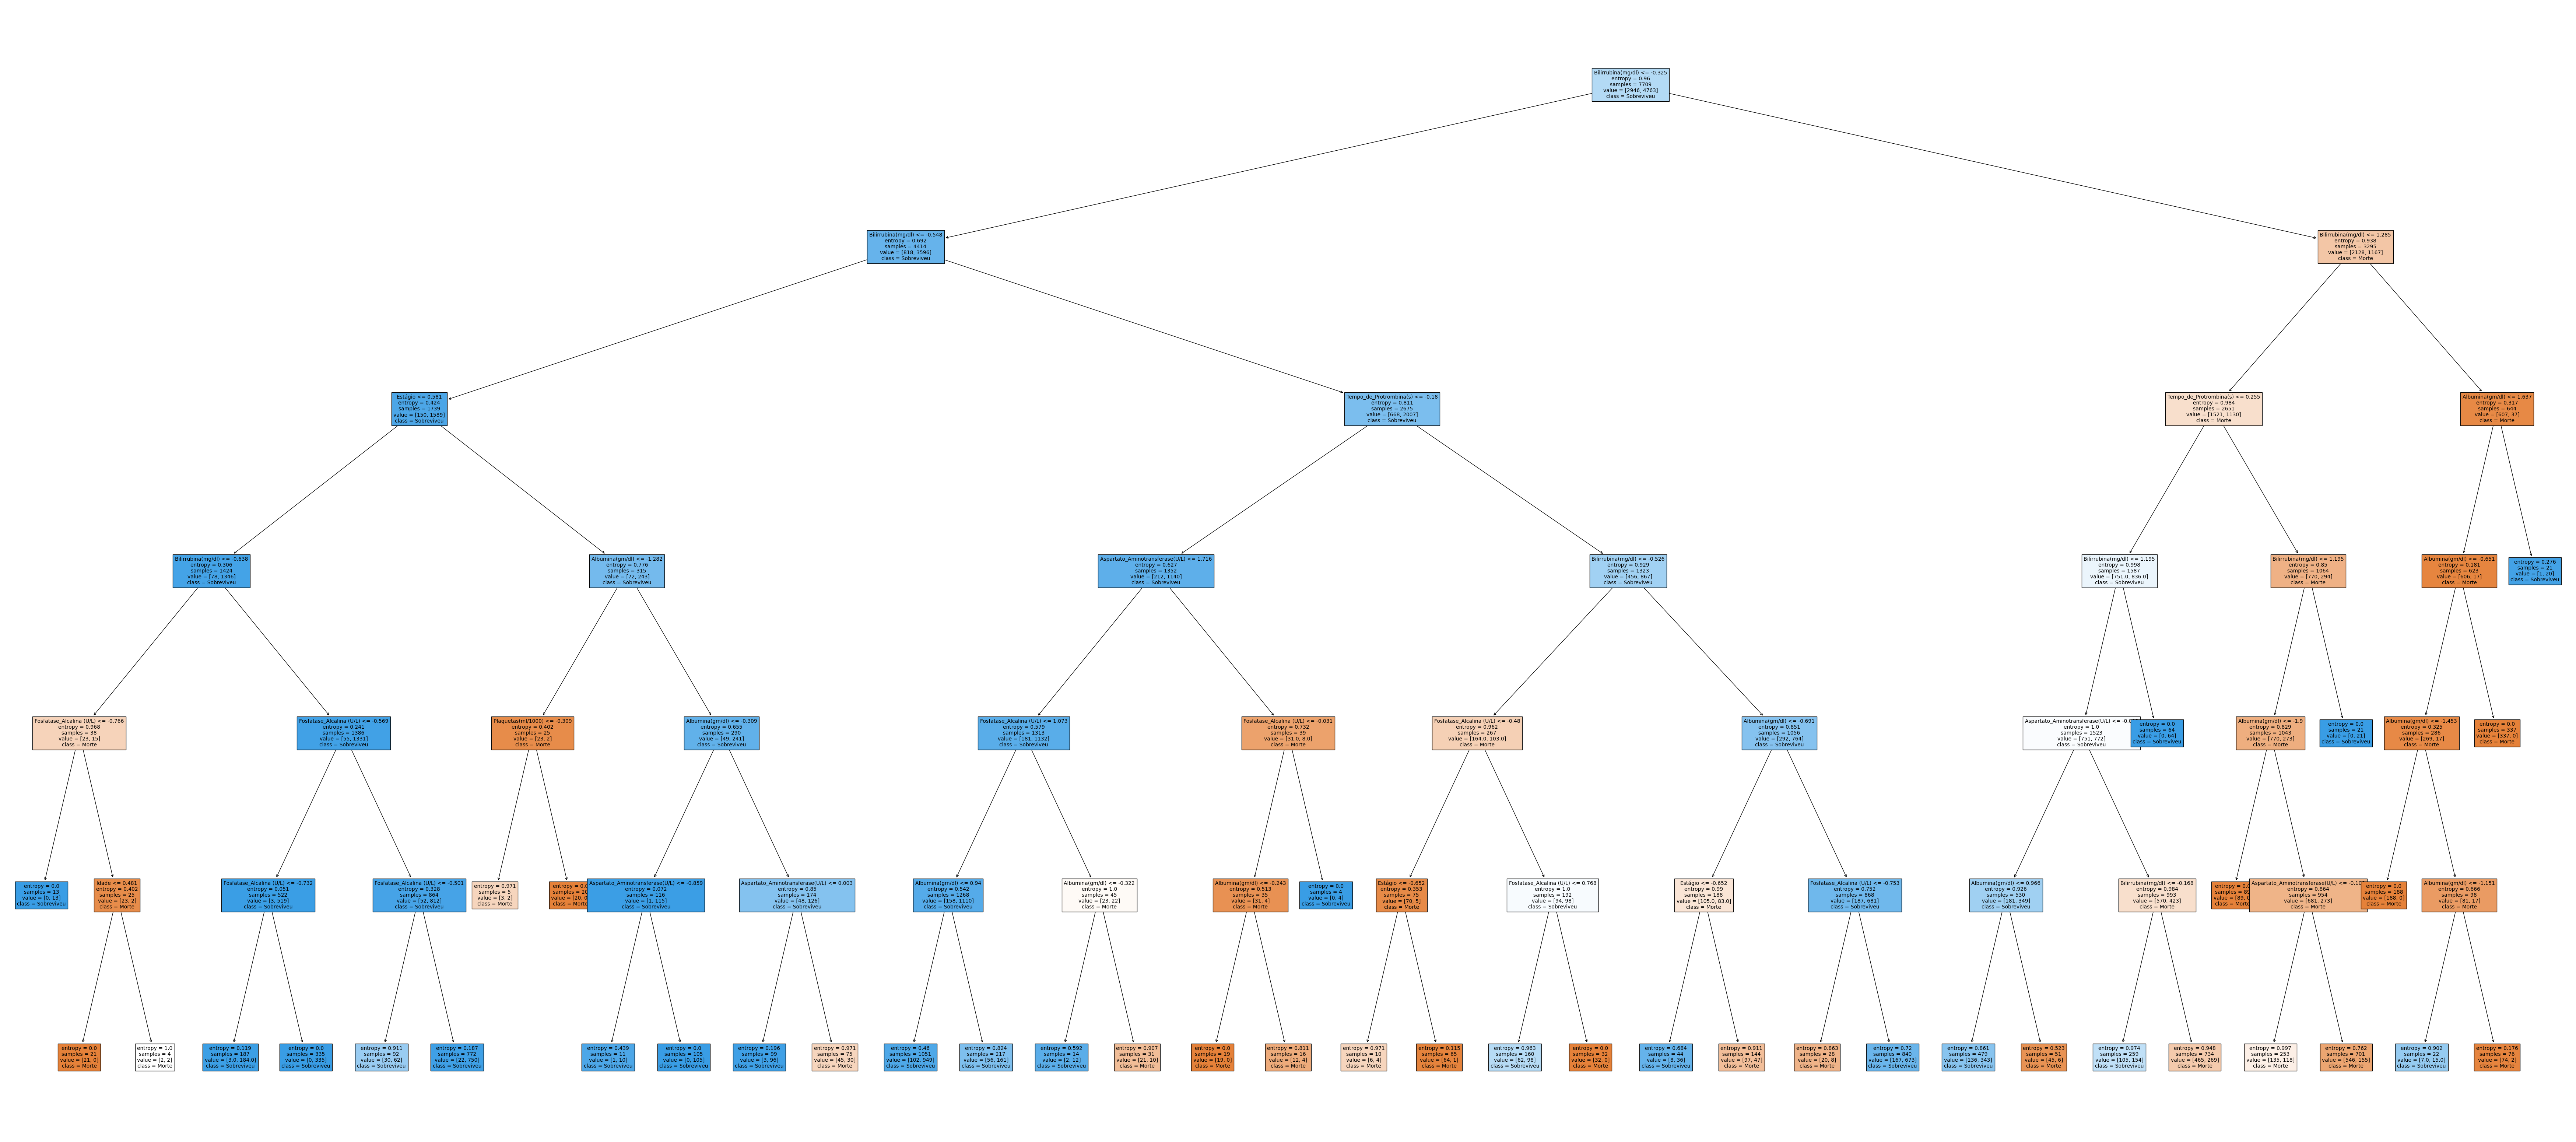

In [36]:
# Plottar a Árvore de Decisão Corrigida
fig_2 = plt.figure(figsize=(90,40))
_ = tree.plot_tree(clf_ccp2,
                      feature_names=df2.drop(columns=['Situação']).columns,
                      class_names=clf_ccp2.classes_,
                      filled=True,
                      fontsize=10,
                      )

plt.show()

In [37]:
# Salvando os modelos de árvore de decisão para uso futuro
print("O modelo de Árvore de Decisão foi salvo em:")
print(dump(clf2, 'models/death_tree2.joblib'))

print("O modelo de Árvore de Decisão Corrigida foi salvo em:")
print(dump(clf_ccp2, 'models/death_tree_fixed2.joblib'))

O modelo de Árvore de Decisão foi salvo em:
['models/death_tree2.joblib']
O modelo de Árvore de Decisão Corrigida foi salvo em:
['models/death_tree_fixed2.joblib']


---
# Classificação 3: Ignorando Evento Transplante
---

## Limpeza e Transformação

In [ ]:
df3 = df.copy()

# Retira as linhas que possuem a coluna 'Situação' com o valor 'Transplante'
df3 = df3[df3['Situação'] != 'Transplante']

# Transforma a coluna 'Situação' em binário
df3['Situação'] = df3['Situação'].replace({'Morte': 1, 'Sobreviveu': 0})

# Renomeia a coluna 'Situação' para 'Morte'
df3 = df3.rename(columns={'Situação': 'Morte'})

# Mostra as primeiras linhas do dataset
df3

* Retirada dos dados que possuiam Transplante na Situação
* Substituição dos dados, Morte = 1 e Sobreviveu = 0
* Mudança no nome da coluna de Situação para Morte

## Separação e Normalização de dados

In [ ]:
# Definição das variáveis independentes e dependentes
X = np.array(df3[['Idade','Bilirrubina(mg/dl)','Albumina(gm/dl)','Fosfatase_Alcalina (U/L)','Aspartato_Aminotransferase(U/L)','Plaquetas(ml/1000)','Tempo_de_Protrombina(s)','Estágio']])
Y = np.array(df3['Morte'])

# Divisão dos dados em treino e teste (80% treino e 20% teste)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

# Normalização dos Dados                                                              
scaler3 = StandardScaler()
scaler3.fit(x_train)
x_test = scaler3.transform(x_test)
x_train = scaler3.transform(x_train)

# Salva o scaler
print("O modelo do scaler foi salvo em:")
dump(scaler3, 'scalers/death_scaler3.joblib')

# Mostra o tamanho dos dados de treino e teste
print("Tamanho treinamento: " + str(len(x_train)))
print("Tamanho teste: " + str(len(x_test)))


* Divisão dos dados para treino e Teste 
* Normalização para que a distribuição do teste fique próxima da do treino
* Salva Scaler

## Regressão Logística

In [ ]:
# Transformando o Label para Morte e Sobreviveu
lrY_train = ['Morte' if value == 1 else 'Sobreviveu' for value in y_train]
lrY_test = ['Morte' if value == 1 else 'Sobreviveu' for value in y_test]

# Instancia Regressão Logistica
classifier = LogisticRegression(max_iter=5000, n_jobs=-1)

# Fit do Classificador
classifier.fit(x_train, lrY_train)

# Erro do treino
N_inputs = len(lrY_train)

# Predição do treino
class_pred = classifier.predict(x_train)

# Contador de erro
eIn = 0

# Calculando o erro
for i in range(N_inputs):
    # Se a classe predita for diferente da classe real, some 1 ao erro
    if(class_pred[i] != lrY_train[i]):
        eIn += 1

# Calculando a porcentagem de erro
eIn /= N_inputs

# Mostra o erro no treino
print("Ein = " + str(eIn))

# Erro do teste
N_out = len(lrY_test)

# Realiza Predição no teste :
class_pred = classifier.predict(x_test)

# Contador de erro
eOut = 0
for i in range(N_out):
    # Se a classe predita for diferente da classe real, some 1 ao erro
    if(class_pred[i] != lrY_test[i]):
        eOut += 1

# Calculando a porcentagem de erro
eOut /= N_out

# Mostra o erro no teste
print("Eout = " + str(eOut))  # Erro no teste

# Mostra Relatório de Classificação
print(classification_report(lrY_test, class_pred))

# Salva o modelo 
print("O modelo de Regressão Logística foi salvo em:")
dump(scaler3, 'models/death_logreg3.joblib')


* Porcentagem de erro do teste e de treino próximas.
* Acurácia em torno de 73, porém a revocação para a classse morte é baixa indicando um deficit para a classificação do evento morte.


### Matriz de Confusão

In [ ]:
# Cria a matriz de confusão
cm = confusion_matrix(lrY_test, class_pred)
print(cm)

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Morte', 'Sobreviveu'], yticklabels=['Morte', 'Sobreviveu'])
plt.xlabel('Prevista')
plt.ylabel('Real')
plt.title('Matriz de Confusão')

# Mostra a matriz de confusão
plt.show()

De Cima Para Baixo da Esquerda para a Direita:
* True Positive (Previsto como Sobreviveu e era Sobreviveu)
* False Negative (Previsto como Morte mas era Sobreviveu)
* False Positive (Previsto como Sobreviveu mas era Morte) 
* True Negative (Previsto como Morte e era Morte) 

## Árvore de Decisão

In [ ]:
# Instanciar a árvore de decisão
arvore_decisao = DecisionTreeClassifier()

# Ajustar o modelo (fit)
arvore_decisao.fit(x_train, lrY_train)

# Fazer previsões
class_pred_arvore = arvore_decisao.predict(x_test)

# Imprimir o relatório de classificação
print(classification_report(lrY_test, class_pred_arvore))


* Acurácia em torno de 93% indicando uma melhora em relação à Regressão Logística
* Médias e Revocação Indicam que o modelo está Balanceado.

### Minimal Cost Complexity Pruning

In [ ]:
# Importação do classificador de Árvore de Decisão
clf = DecisionTreeClassifier()

# Cálculo do Caminho de Poda de Complexidade de Custos
path = clf.cost_complexity_pruning_path(x_train, y_train)

# Definição do Grid de Parâmetros para a busca em grade
param_grid = {'ccp_alpha': path.ccp_alphas}

# Configuração da Validação Cruzada com GridSearchCV
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 7, verbose=2, n_jobs=-1)

# Treinamento do Modelo com GridSearchCV
CV_clf.fit(x_train, y_train)

# Melhor valor de ccp_alpha
ccp_alpha = CV_clf.best_params_['ccp_alpha']


In [ ]:
# Cria uma nova árvore de decisão com o melhor ccp_alpha e definindo limite e niveis
nova_arvore = DecisionTreeClassifier(ccp_alpha=ccp_alpha, max_depth=5)

# Ajusta a nova árvore aos dados de treinamento
nova_arvore.fit(x_train, lrY_train)

# Faz previsões com a nova árvore
class_pred_arvore = nova_arvore.predict(x_test)

# Imprime o relatório de classificação
print(classification_report(lrY_test, class_pred_arvore))

* Acurácia em torno de 82% (possivelmente devido ao limite de niveis)
* Revocação e médias indica balanceamento entre as classes

In [ ]:
# Cria uma figura para a árvore
plt.figure(figsize=(20, 15))

# Plota a árvore 
plot_tree(nova_arvore, filled=True, class_names=["Sobreviveu", "Morte"], fontsize=10)

# Mostra o gráfico
plt.show()

* A Imagem acima mostra a forma que a árvore de decisão funciona.

In [ ]:
# Salva o modelo 
print("O modelo de Árvore de Decisão foi salvo em:")
dump(scaler3, 'models/death_tree3.joblib')